Original User-Item Rating Matrix:
         Movie 1  Movie 2  Movie 3  Movie 4  Movie 5  Movie 6  Movie 7  \
User 1         5        0        2        2        2        4        0   
User 2         0        0        2        2        0        2        4   
User 3         2        0        4        4        1        5        5   
User 4         5        1        5        4        5        5        5   
User 5         2        5        2        3        0        3        0   
User 6         0        5        5        3        1        2        0   
User 7         0        1        0        2        3        2        0   
User 8         0        4        3        4        5        3        5   
User 9         2        0        0        1        1        4        0   
User 10        5        5        2        4        1        4        4   

         Movie 8  
User 1         5  
User 2         5  
User 3         0  
User 4         0  
User 5         0  
User 6         3  
User 7         1  

<ipython-input-9-d4e990e32a0d>:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_based_predictions.iloc[user_index, :] = user_mean_ratings[user_index] + weighted_ratings / (np.abs(similarity_scores).sum() + 1e-9)
<ipython-input-9-d4e990e32a0d>:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.646541760569426' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  user_based_predictions.iloc[user_index, :] = user_mean_ratings[user_index] + weighted_ratings / (np.abs(similarity_scores).sum() + 1e-9)
<ipython-input-9-d4e990e32a0d>:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7695581655726964' has dtype incompatible 

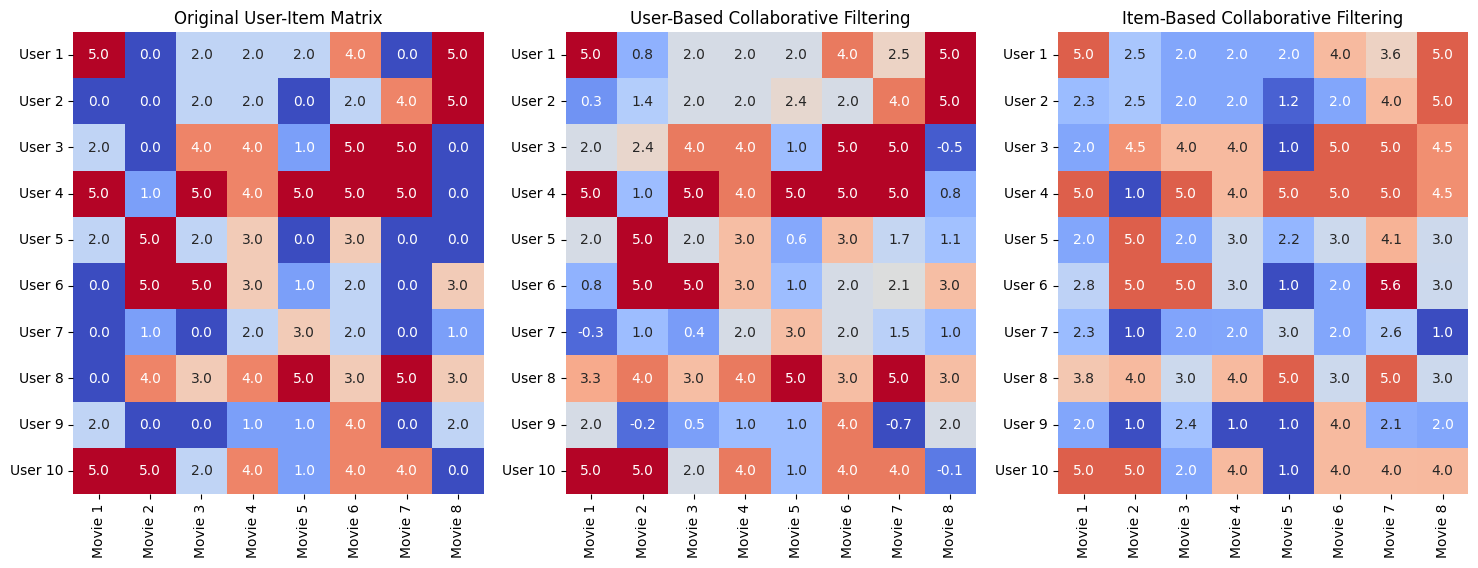

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def generate_ratings_matrix(num_users, num_items):

    ratings_data = []
    for user_index in range(num_users):
        user_ratings = [np.random.randint(1, 6) if np.random.rand() > 0.3 else 0 for _ in range(num_items)]
        ratings_data.append(user_ratings)
    ratings_matrix = pd.DataFrame(ratings_data)
    ratings_matrix.index = [f"User {user_index + 1}" for user_index in range(num_users)]
    ratings_matrix.columns = [f"Movie {item_index + 1}" for item_index in range(num_items)]
    return ratings_matrix

def compute_cosine_similarity(matrix, labels):
    similarity_matrix = cosine_similarity(matrix)
    np.fill_diagonal(similarity_matrix, 0)
    return pd.DataFrame(similarity_matrix, index=labels, columns=labels)

def predict_ratings_user_based(rating_matrix, k=2):
    user_similarity = compute_cosine_similarity(rating_matrix.fillna(0).values, rating_matrix.index)
    user_mean_ratings = rating_matrix.replace(0, np.nan).mean(axis=1)
    ratings_diff = (rating_matrix.T - user_mean_ratings).T

    user_based_predictions = rating_matrix.copy()
    for user_index in range(rating_matrix.shape[0]):
        top_k_similar_users = np.argsort(user_similarity.iloc[user_index].values)[-k:]
        similarity_scores = user_similarity.iloc[user_index, top_k_similar_users].values
        weighted_ratings = np.dot(similarity_scores, ratings_diff.iloc[top_k_similar_users].fillna(0).values)
        user_based_predictions.iloc[user_index, :] = user_mean_ratings[user_index] + weighted_ratings / (np.abs(similarity_scores).sum() + 1e-9)

    user_based_predictions[rating_matrix != 0] = rating_matrix[rating_matrix != 0]  # Keep original ratings
    return user_based_predictions

def predict_ratings_item_based(rating_matrix, k=2):
    item_similarity = compute_cosine_similarity(rating_matrix.T.fillna(0).values, rating_matrix.columns)
    item_mean_ratings = rating_matrix.replace(0, np.nan).mean(axis=0)
    ratings_diff = rating_matrix - item_mean_ratings

    item_based_predictions = rating_matrix.copy()
    for item_index in range(rating_matrix.shape[1]):
        top_k_similar_items = np.argsort(item_similarity.iloc[item_index].values)[-k:]
        similarity_scores = item_similarity.iloc[item_index, top_k_similar_items].values
        weighted_ratings = np.dot(similarity_scores, ratings_diff.iloc[:, top_k_similar_items].fillna(0).values.T)
        item_based_predictions.iloc[:, item_index] = item_mean_ratings[item_index] + weighted_ratings / (np.abs(similarity_scores).sum() + 1e-9)

    item_based_predictions[rating_matrix != 0] = rating_matrix[rating_matrix != 0]  # Keep original ratings
    return item_based_predictions

def plot_rating_matrices(original_matrix, user_based_matrix, item_based_matrix):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    sns.heatmap(original_matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar=False)
    plt.title("Original User-Item Matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(user_based_matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar=False)
    plt.title("User-Based Collaborative Filtering")

    plt.subplot(1, 3, 3)
    sns.heatmap(item_based_matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar=False)
    plt.title("Item-Based Collaborative Filtering")

    plt.show()

num_users = 10
num_items = 8
rating_matrix = generate_ratings_matrix(num_users, num_items)
print("Original User-Item Rating Matrix:")
print(rating_matrix)

user_based_matrix = predict_ratings_user_based(rating_matrix, k=2)
item_based_matrix = predict_ratings_item_based(rating_matrix, k=2)

plot_rating_matrices(rating_matrix, user_based_matrix, item_based_matrix)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

def load_data():
    ratings_path = '/content/ratings.csv'
    movies_path = '/content/movies.csv'
    tags_path = '/content/tags.csv'
    links_path = '/content/links.csv'

    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)
    tags = pd.read_csv(tags_path)
    links = pd.read_csv(links_path)
    return ratings, movies, tags, links

def analyze_data(ratings, movies):
    unique_movies = ratings['movieId'].nunique()
    unique_ratings = ratings['rating'].nunique()
    user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

    print(f"Number of unique movies: {unique_movies}")
    print(f"Number of unique ratings: {unique_ratings}")

    return user_movie_matrix

def mean_recommender(user_movie_matrix):
    movie_means = user_movie_matrix.mean(axis=0)
    mean_filled_matrix = user_movie_matrix.apply(lambda row: row.fillna(movie_means), axis=1)

    top_5_movies = movie_means.sort_values(ascending=False).head(5)
    return mean_filled_matrix, top_5_movies

def svd_recommender(user_movie_matrix, n_components=20):
    user_movie_matrix_filled = user_movie_matrix.fillna(0)

    svd = TruncatedSVD(n_components=n_components)
    latent_matrix = svd.fit_transform(user_movie_matrix_filled)

    reconstructed_matrix = np.dot(latent_matrix, svd.components_)
    reconstructed_matrix_df = pd.DataFrame(reconstructed_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

    top_5_movies_svd = reconstructed_matrix_df.mean(axis=0).sort_values(ascending=False).head(5)
    return reconstructed_matrix_df, top_5_movies_svd

def analyze_results(top_5_mean, top_5_svd):
    print("Top 5 movies recommended by Mean Recommender System:")
    print(top_5_mean)

    print("\nTop 5 movies recommended by SVD Recommender System:")
    print(top_5_svd)

def discuss_cold_start():
    print("\nCold Start Problem:")
    print("The cold start problem arises when making recommendations for new users or items with little to no historical data.")
    print("The mean recommender may handle this better since it relies on average ratings, whereas SVD requires more data for accurate predictions.")

def main():
    ratings, movies, tags, links = load_data()
    user_movie_matrix = analyze_data(ratings, movies)
    mean_filled_matrix, top_5_mean = mean_recommender(user_movie_matrix)
    reconstructed_matrix_df, top_5_svd = svd_recommender(user_movie_matrix)
    analyze_results(top_5_mean, top_5_svd)
    discuss_cold_start()

if __name__ == "__main__":
    main()


Number of unique movies: 9724
Number of unique ratings: 10
Top 5 movies recommended by Mean Recommender System:
movieId
88448     5.0
100556    5.0
143031    5.0
143511    5.0
143559    5.0
dtype: float64

Top 5 movies recommended by SVD Recommender System:
movieId
356     2.127009
318     2.126302
296     2.039742
593     1.827792
2571    1.741045
dtype: float64

Cold Start Problem:
The cold start problem arises when making recommendations for new users or items with little to no historical data.
The mean recommender may handle this better since it relies on average ratings, whereas SVD requires more data for accurate predictions.
